https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.kaggle.com/a7madmostafa/denoising-images-using-conv-autoencoders

를 참고하였다.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/Denoising Astral Photos'

img_list = sorted(os.listdir(path + '/X'))
cleaned_img_list = sorted(os.listdir(path + '/y'))

In [6]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (1200, 1200))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (1200, 1200, 1))
    
    return img

In [7]:
# preprocess images
train = []
train_cleaned = []

for f in sorted(os.listdir(path + '/X')):
    train.append(process_image(path + '/X/' + f))

for f in sorted(os.listdir(path + '/y')):
    train_cleaned.append(process_image(path + '/y/' + f))

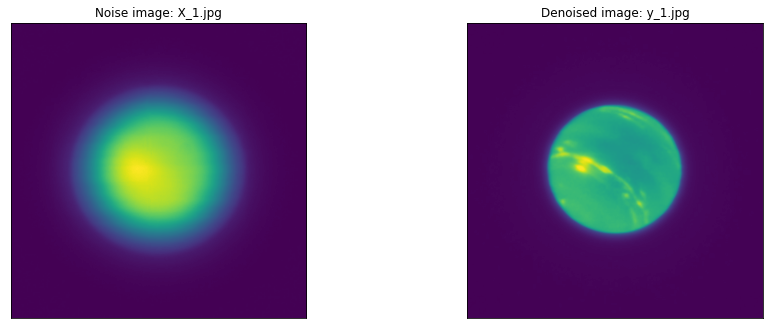

In [8]:
plt.figure(figsize=(15,25))
for i in range(1):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0])
    plt.title('Noise image: {}'.format(img_list[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0])
    plt.title('Denoised image: {}'.format(cleaned_img_list[i]))

plt.show()

In [9]:
# convert list to numpy array
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_val = X_train
y_val = y_train

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1)

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses
from keras.callbacks import EarlyStopping
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

In [11]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=[1200, 1200, 1]),
            #preprocessing.RandomRotation(factor=0.15),
            layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            layers.MaxPool2D((2,2), padding='same'),
            layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            layers.MaxPool2D((2,2), padding='same'),
            
        ])
        
        self.decoder = keras.Sequential([        
            layers.Conv2DTranspose(64, (3,3), strides = 2, activation='relu', padding='same'),
            layers.Conv2DTranspose(128, (3,3), strides = 2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [12]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(X_train, y_train,
                epochs=200,
                batch_size=16,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping])

Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.1983 - val_loss: 0.1969
Epoch 2/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1969 - val_loss: 0.1954
Epoch 3/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1954 - val_loss: 0.1936
Epoch 4/200
1/1 [==============================] - 0s 262ms/step - loss: 0.1936 - val_loss: 0.1913
Epoch 5/200
1/1 [==============================] - 0s 253ms/step - loss: 0.1913 - val_loss: 0.1886
Epoch 6/200
1/1 [==============================] - 0s 252ms/step - loss: 0.1886 - val_loss: 0.1853
Epoch 7/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1853 - val_loss: 0.1812
Epoch 8/200
1/1 [==============================] - 0s 255ms/step - loss: 0.1812 - val_loss: 0.1762
Epoch 9/200
1/1 [==============================] - 0s 254ms/step - loss: 0.1762 - val_loss: 0.1698
Epoch 10/200
1/1 [==============================] - 0s 260ms/step - loss: 0.1698 - val_loss: 0.1618
Epoch 11/2

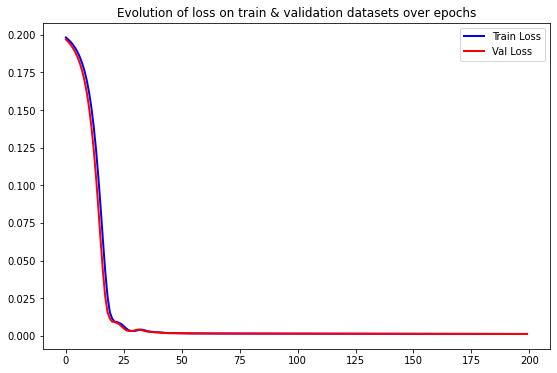

In [14]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [15]:
y_pred = autoencoder.predict(X_test, batch_size=16)

NameError: ignored

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()